In [104]:
from os import listdir
import pandas as pd
from collections import defaultdict
from datetime import datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt

In [105]:
# Data source: http://web.mta.info/developers/turnstile.html
datafiles = ['../data/' + x for x in listdir('../data/')]

list_ = []
for file_ in datafiles:
    df = pd.read_csv(file_)
    list_.append(df)
frame = pd.concat(list_)

print frame.shape
frame.head(10)

# Slice a limited sample to speed up processing
# frame = frame[:50000]

(777253, 11)


,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456,BMT,05/21/2016,00:00:00,REGULAR,5672118,1920707
1,A002,R051,02-00-00,59 ST,NQR456,BMT,05/21/2016,04:00:00,REGULAR,5672183,1920719
2,A002,R051,02-00-00,59 ST,NQR456,BMT,05/21/2016,08:00:00,REGULAR,5672214,1920761
3,A002,R051,02-00-00,59 ST,NQR456,BMT,05/21/2016,12:00:00,REGULAR,5672330,1920867
4,A002,R051,02-00-00,59 ST,NQR456,BMT,05/21/2016,16:00:00,REGULAR,5672640,1920936
5,A002,R051,02-00-00,59 ST,NQR456,BMT,05/21/2016,20:00:00,REGULAR,5673031,1921000
6,A002,R051,02-00-00,59 ST,NQR456,BMT,05/22/2016,00:00:00,REGULAR,5673268,1921052
7,A002,R051,02-00-00,59 ST,NQR456,BMT,05/22/2016,04:00:00,REGULAR,5673298,1921061
8,A002,R051,02-00-00,59 ST,NQR456,BMT,05/22/2016,08:00:00,REGULAR,5673312,1921080
9,A002,R051,02-00-00,59 ST,NQR456,BMT,05/22/2016,12:00:00,REGULAR,5673379,1921156


In [106]:
# Build dictionary for challenge 1

device_audits = defaultdict(list)

for index, row in frame.iterrows():
    device_audits[tuple(row[0:4])].append(row[4:].tolist())
    
print len(device_audits)


4603


In [107]:
# Build dictionary for challenge 2
# datetime, entries

device_audits = defaultdict(list)

for index, row in frame.iterrows():
    dstr = row['DATE'] + ' ' + row['TIME']
    dt = datetime.strptime(dstr, '%m/%d/%Y %H:%M:%S')
    en = row[u'ENTRIES']
    device_audits[tuple(row[0:4])].append([dt,en])
    
print len(device_audits)

4603


## Times

Audits are usually taken every 4 hours, but there are also irregular audits in the data.  The DESC variable indicates whether a particular audit was taken regularly or not (http://web.mta.info/developers/resources/nyct/turnstile/ts_Field_Description.txt).  Samples may be taken irregularly due to planning or troubleshooting activities.

In [108]:
print "Count of audit types"
for s in set(frame["DESC"]):
    ct = frame["DESC"].tolist().count(s)
    print "%s: %d"%(s,ct)

Count of audit types
REGULAR: 774162
RECOVR AUD: 3091


In [122]:
# Challenge 3

# Collapse a list of audits so that all audits on the same are combined into one
def collapse_days(l):
    day_entries = []
    dayset = sorted(set([x[0].date() for x in l]))
    for day in dayset:
        entries = sum([x[1] for x in l if x[0].date() == day])
        day_entries.append((day, entries))
    return day_entries

# Test collapse_days
delta1 = timedelta(days=1)
print collapse_days([[datetime.now(), 5], [datetime.now(), 2], [datetime.now() - delta1, 2]])

device_audits_daily = defaultdict(list)
for key,value in device_audits.iteritems():
    device_audits_daily[key] = collapse_days(value)
    
print device_audits_daily.iteritems().next()

[(datetime.date(2016, 6, 27), 2), (datetime.date(2016, 6, 28), 7)]
(('N134', 'R385', '00-00-00', 'ROCKAWAY BLVD'), [(datetime.date(2016, 5, 21), 43861987), (datetime.date(2016, 5, 22), 43866444), (datetime.date(2016, 5, 23), 43873092), (datetime.date(2016, 5, 24), 43882307), (datetime.date(2016, 5, 25), 43891591), (datetime.date(2016, 5, 26), 43901249), (datetime.date(2016, 5, 27), 43910468), (datetime.date(2016, 5, 28), 43916956), (datetime.date(2016, 5, 29), 43921250), (datetime.date(2016, 5, 30), 43925377), (datetime.date(2016, 5, 31), 43931963), (datetime.date(2016, 6, 1), 43940498), (datetime.date(2016, 6, 2), 43949375), (datetime.date(2016, 6, 3), 43958166), (datetime.date(2016, 6, 4), 43965107), (datetime.date(2016, 6, 5), 43969624), (datetime.date(2016, 6, 6), 43976066), (datetime.date(2016, 6, 7), 43985378), (datetime.date(2016, 6, 8), 43994976), (datetime.date(2016, 6, 9), 44003668), (datetime.date(2016, 6, 10), 44012410), (datetime.date(2016, 6, 11), 44018914), (datetime.dat

('PTH08', 'R540', '00-01-06', 'PATH WTC')


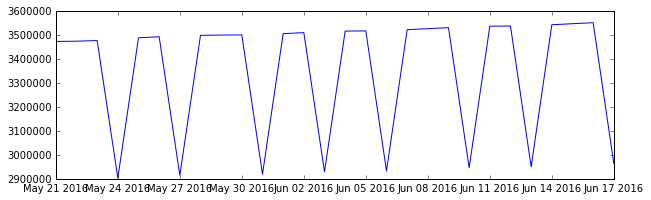

In [123]:
# Challenge 4

%matplotlib inline


turnstiles = device_audits_daily.iteritems()
for i in range(3):
    stile = turnstiles.next()

print stile[0]
ts_data = np.array(stile[1])

dates = ts_data[:,0]
counts = ts_data[:,1]


plt.figure(figsize=(10,3))
plt.plot(dates,counts)